In [ ]:
print("="*70)
print("CircuitGuard - Module 4: Evaluation and Prediction Testing")
print("="*70)

from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
print("\n📦 Installing required libraries...")
!pip install -q torch torchvision
!pip install -q timm
!pip install -q scikit-learn
!pip install -q seaborn

print("✅ Libraries installed successfully!\n")

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
from collections import defaultdict
import pandas as pd


# PyTorch imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import timm

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Using device: {device}")

CircuitGuard - Module 4: Evaluation and Prediction Testing
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📦 Installing required libraries...
object address  : 0x7adac1bcf2e0
object refcount : 3
object type     : 0xa2a4e0
object type name: KeyboardInterrupt
object repr     : KeyboardInterrupt()
lost sys.stderr
^C
✅ Libraries installed successfully!


🖥️ Using device: cpu


In [9]:
import pickle
from google.colab import files
import torch

# For robustness, redefining PROJECT_ROOT and MODELS_PATH
PROJECT_ROOT = '//content//drive//MyDrive//CircuitGuard_Project' # Ensure this matches your project root
MODELS_PATH = f'{PROJECT_ROOT}/models'
MODEL_PATH = f'{MODELS_PATH}/best_efficientnet_model.pth'

# Define path for the pickle file
model_state_dict_pkl_path = f'{MODELS_PATH}/efficientnet_state_dict.pkl'

# Load the checkpoint to get the state_dict
# Using map_location='cpu' to ensure it loads even if a GPU is not available or if the original device is different
checkpoint = torch.load(MODEL_PATH, map_location='cpu')

# Extract the model's state_dict from the loaded checkpoint
state_dict_to_save = checkpoint['model_state_dict']

# Save the state_dict as a pickle file
with open(model_state_dict_pkl_path, 'wb') as f:
    pickle.dump(state_dict_to_save, f)

print(f"✅ Model state_dict saved as pickle to: {model_state_dict_pkl_path}")

# Download the pickle file
try:
    files.download(model_state_dict_pkl_path)
    print(f"✅ Successfully initiated download for efficientnet_state_dict.pkl")
except Exception as e:
    print(f"❌ Error downloading the pickle file: {e}")
    print("Please ensure the file exists and you have permissions.")

✅ Model state_dict saved as pickle to: //content//drive//MyDrive//CircuitGuard_Project/models/efficientnet_state_dict.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Successfully initiated download for efficientnet_state_dict.pkl


In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive remounted. Check if you can now write to files.")

Mounted at /content/drive
✅ Google Drive remounted. Check if you can now write to files.


In [ ]:
#Load Project Configuration
# Project paths
PROJECT_ROOT = '/content/drive/MyDrive/CircuitGuard_Project'
DATASET_PATH = f'{PROJECT_ROOT}/dataset/PCB_DATASET'
TRAINING_DATASET_PATH = f'{PROJECT_ROOT}/training_dataset'

# Input paths
IMAGES_PATH = f'{DATASET_PATH}/images'
ANNOTATIONS_PATH = f'{DATASET_PATH}/Annotations'
TEST_PATH = f'{TRAINING_DATASET_PATH}/test'

# Model path
MODELS_PATH = f'{PROJECT_ROOT}/models'
MODEL_PATH = f'{MODELS_PATH}/best_efficientnet_model.pth'

# Output paths
OUTPUT_ROOT = f'{PROJECT_ROOT}/outputs'
PREDICTIONS_PATH = f'{OUTPUT_ROOT}/predictions'
ANNOTATED_IMAGES_PATH = f'{OUTPUT_ROOT}/annotated_images'
VISUALIZATIONS_PATH = f'{OUTPUT_ROOT}/visualizations'
REPORTS_PATH = f'{OUTPUT_ROOT}/reports'

# Create output directories
os.makedirs(PREDICTIONS_PATH, exist_ok=True)
os.makedirs(ANNOTATED_IMAGES_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

# Load Module 3 metadata
metadata_path = f'{PROJECT_ROOT}/module3_metadata.json'
with open(metadata_path, 'r') as f:
    module3_metadata = json.load(f)

class_names = module3_metadata['dataset']['class_names']
num_classes = module3_metadata['dataset']['num_classes']

print(f"\n✅ Loaded Module 3 metadata")
print(f"✅ Model path: {MODEL_PATH}")
print(f"✅ Number of classes: {num_classes}")
print(f"✅ Classes: {class_names}")


✅ Loaded Module 3 metadata
✅ Model path: /content/drive/MyDrive/CircuitGuard_Project/models/best_efficientnet_model.pth
✅ Number of classes: 6
✅ Classes: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']


In [ ]:
# Load Trained Model
# Create model architecture
model = timm.create_model('efficientnet_b4', pretrained=False, num_classes=num_classes)

# Load trained weights
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✅ Model loaded successfully")
print(f"✅ Model trained for: {checkpoint['epoch']+1} epochs")
print(f"✅ Best validation accuracy: {checkpoint['val_acc']:.2f}%")


✅ Model loaded successfully
✅ Model trained for: 24 epochs
✅ Best validation accuracy: 97.31%


In [ ]:
#define Inference Pipeline
print("\n" + "="*70)
print("STEP 3: Setting Up Inference Pipeline")
print("="*70)

# Define transforms (same as validation)
inference_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, model, transforms, device, class_names):
    """
    Predict defect class for a single image

    Args:
        image_path: Path to image file
        model: Trained model
        transforms: Image transforms
        device: Device to run inference on
        class_names: List of class names

    Returns:
        predicted_class: Predicted class name
        confidence: Prediction confidence (0-1)
        all_probs: Probabilities for all classes
    """

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transforms(image).unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    predicted_class = class_names[predicted_idx.item()]
    confidence_value = confidence.item()
    all_probs = probabilities.cpu().numpy()[0]

    return predicted_class, confidence_value, all_probs

def parse_xml_annotation(xml_file):
    """Parse Pascal VOC XML annotation file"""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        annotation = {
            'filename': root.find('filename').text,
            'width': int(root.find('size/width').text),
            'height': int(root.find('size/height').text),
            'objects': []
        }

        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            obj_data = {
                'name': obj.find('name').text,
                'xmin': int(bbox.find('xmin').text),
                'ymin': int(bbox.find('ymin').text),
                'xmax': int(bbox.find('xmax').text),
                'ymax': int(bbox.find('ymax').text)
            }
            annotation['objects'].append(obj_data)

        return annotation
    except Exception as e:
        return None

print("✅ Inference pipeline ready")



STEP 3: Setting Up Inference Pipeline
✅ Inference pipeline ready


✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/sample_predictions.png


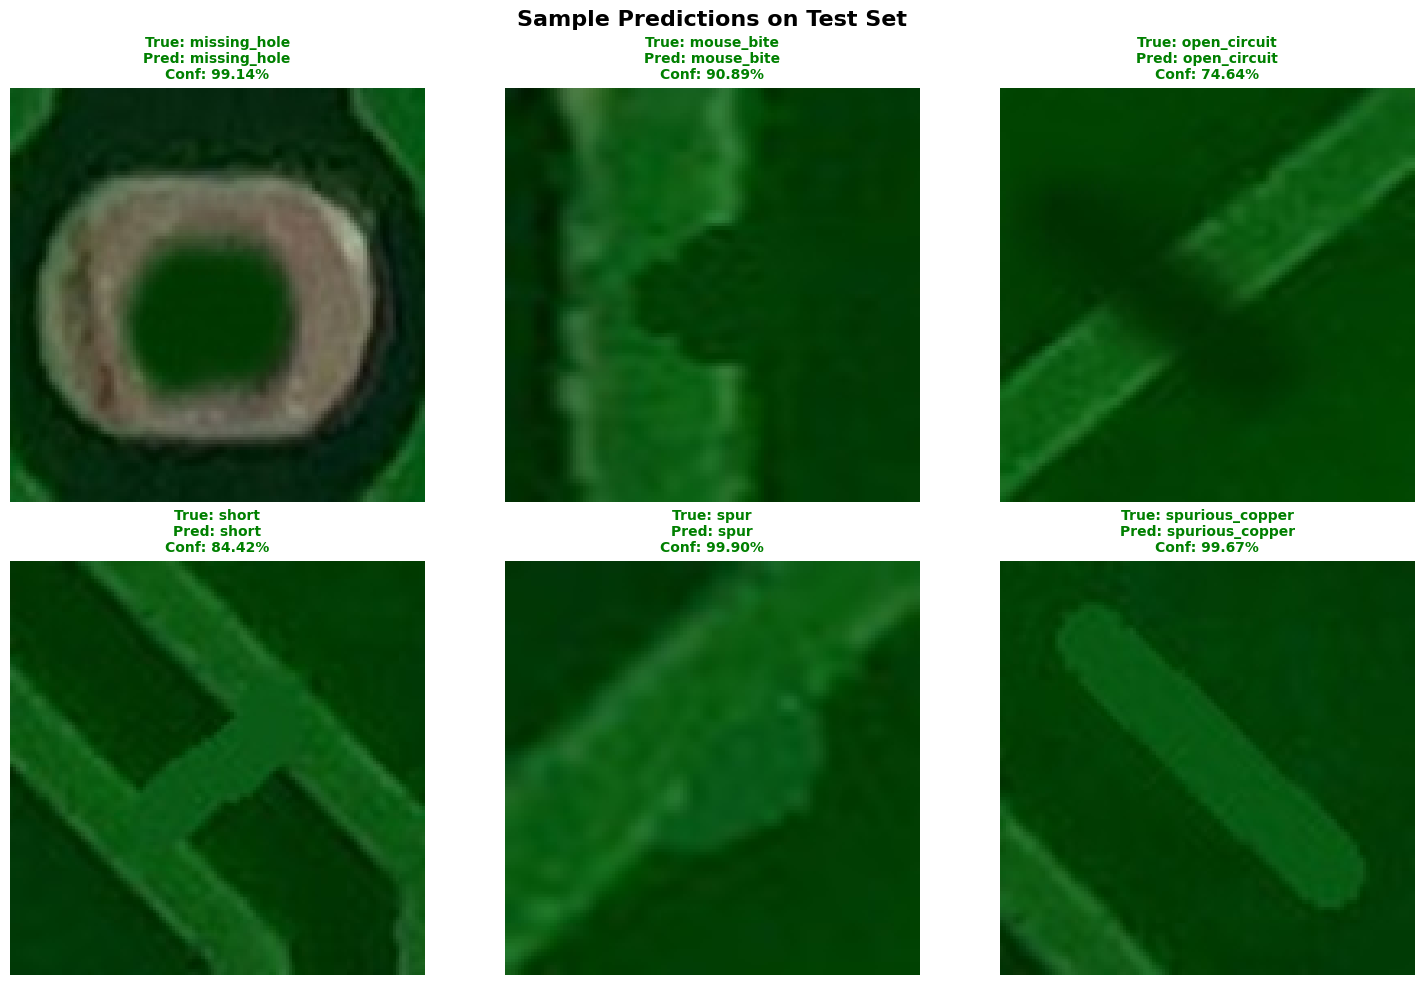

In [ ]:
# Test on Sample Images
def visualize_sample_predictions(num_samples=6):
    """Visualize predictions on sample images from test set"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    fig.suptitle('Sample Predictions on Test Set', fontsize=16, weight='bold')

    sample_count = 0

    # Iterate through test set classes
    for class_name in class_names:
        if sample_count >= num_samples:
            break

        class_path = os.path.join(TEST_PATH, class_name)
        if not os.path.exists(class_path):
            continue

        # Get one sample from this class
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if not image_files:
            continue

        img_file = image_files[0]
        img_path = os.path.join(class_path, img_file)

        # Make prediction
        pred_class, confidence, all_probs = predict_image(
            img_path, model, inference_transforms, device, class_names
        )

        # Load image for display
        img = Image.open(img_path).convert('RGB')

        # Determine if prediction is correct
        is_correct = (pred_class == class_name)
        border_color = 'green' if is_correct else 'red'

        # Display
        axes[sample_count].imshow(img)
        axes[sample_count].set_title(
            f"True: {class_name}\nPred: {pred_class}\nConf: {confidence:.2%}",
            fontsize=10,
            color=border_color,
            weight='bold'
        )
        axes[sample_count].axis('off')

        # Add colored border
        for spine in axes[sample_count].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)

        sample_count += 1

    plt.tight_layout()
    plt.savefig(f'{VISUALIZATIONS_PATH}/sample_predictions.png', dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {VISUALIZATIONS_PATH}/sample_predictions.png")
    plt.show()

visualize_sample_predictions(num_samples=6)


In [ ]:
# Batch Prediction on Test Set
print("\n" + "="*70)
print("STEP 5: Running Batch Predictions on Test Set")
print("="*70)

# Store all predictions
all_predictions = []
prediction_details = []

for class_name in class_names:
    class_path = os.path.join(TEST_PATH, class_name)

    if not os.path.exists(class_path):
        print(f"⚠️ Class path not found: {class_path}")
        continue

    image_files = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"\nProcessing {class_name}: {len(image_files)} images")

    for img_file in tqdm(image_files, desc=f"Predicting {class_name}"):
        img_path = os.path.join(class_path, img_file)

        try:
            # Make prediction
            pred_class, confidence, all_probs = predict_image(
                img_path, model, inference_transforms, device, class_names
            )

            # Store prediction
            prediction_details.append({
                'image_path': img_path,
                'filename': img_file,
                'true_label': class_name,
                'predicted_label': pred_class,
                'confidence': confidence,
                'correct': (pred_class == class_name),
                'probabilities': all_probs.tolist()
            })

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

print(f"\n✅ Total predictions made: {len(prediction_details)}")



STEP 5: Running Batch Predictions on Test Set

Processing missing_hole: 75 images


Predicting missing_hole: 100%|██████████| 75/75 [00:22<00:00,  3.33it/s]



Processing mouse_bite: 74 images


Predicting mouse_bite: 100%|██████████| 74/74 [00:21<00:00,  3.46it/s]



Processing open_circuit: 73 images


Predicting open_circuit: 100%|██████████| 73/73 [00:20<00:00,  3.51it/s]



Processing short: 74 images


Predicting short: 100%|██████████| 74/74 [00:21<00:00,  3.52it/s]



Processing spur: 74 images


Predicting spur: 100%|██████████| 74/74 [00:19<00:00,  3.79it/s]



Processing spurious_copper: 76 images


Predicting spurious_copper: 100%|██████████| 76/76 [00:20<00:00,  3.66it/s]


✅ Total predictions made: 446


In [ ]:
# Calculate Metrics

# Extract true and predicted labels
true_labels = [p['true_label'] for p in prediction_details]
pred_labels = [p['predicted_label'] for p in prediction_details]

# Create label to index mapping
label_to_idx = {name: idx for idx, name in enumerate(class_names)}
true_indices = [label_to_idx[label] for label in true_labels]
pred_indices = [label_to_idx[label] for label in pred_labels]

# Calculate metrics
accuracy = accuracy_score(true_indices, pred_indices)
precision, recall, f1, support = precision_recall_fscore_support(
    true_indices, pred_indices, average='weighted'
)

print(f"\n📊 Overall Performance:")
print(f"  Accuracy:  {accuracy*100:.2f}%")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Per-class metrics
print(f"\n📊 Per-Class Performance:")
per_class_precision, per_class_recall, per_class_f1, per_class_support = \
    precision_recall_fscore_support(true_indices, pred_indices, average=None)

print(f"\n{'Class':<20s} | {'Precision':>10s} | {'Recall':>10s} | {'F1-Score':>10s} | {'Support':>10s}")
print("-" * 75)

for idx, class_name in enumerate(class_names):
    print(f"{class_name:<20s} | {per_class_precision[idx]:>10.4f} | "
          f"{per_class_recall[idx]:>10.4f} | {per_class_f1[idx]:>10.4f} | "
          f"{per_class_support[idx]:>10d}")



📊 Overall Performance:
  Accuracy:  97.76%
  Precision: 0.9776
  Recall:    0.9776
  F1-Score:  0.9775

📊 Per-Class Performance:

Class                |  Precision |     Recall |   F1-Score |    Support
---------------------------------------------------------------------------
missing_hole         |     0.9867 |     0.9867 |     0.9867 |         75
mouse_bite           |     0.9610 |     1.0000 |     0.9801 |         74
open_circuit         |     0.9863 |     0.9863 |     0.9863 |         73
short                |     0.9726 |     0.9595 |     0.9660 |         74
spur                 |     0.9718 |     0.9324 |     0.9517 |         74
spurious_copper      |     0.9870 |     1.0000 |     0.9935 |         76


✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/test_confusion_matrix.png


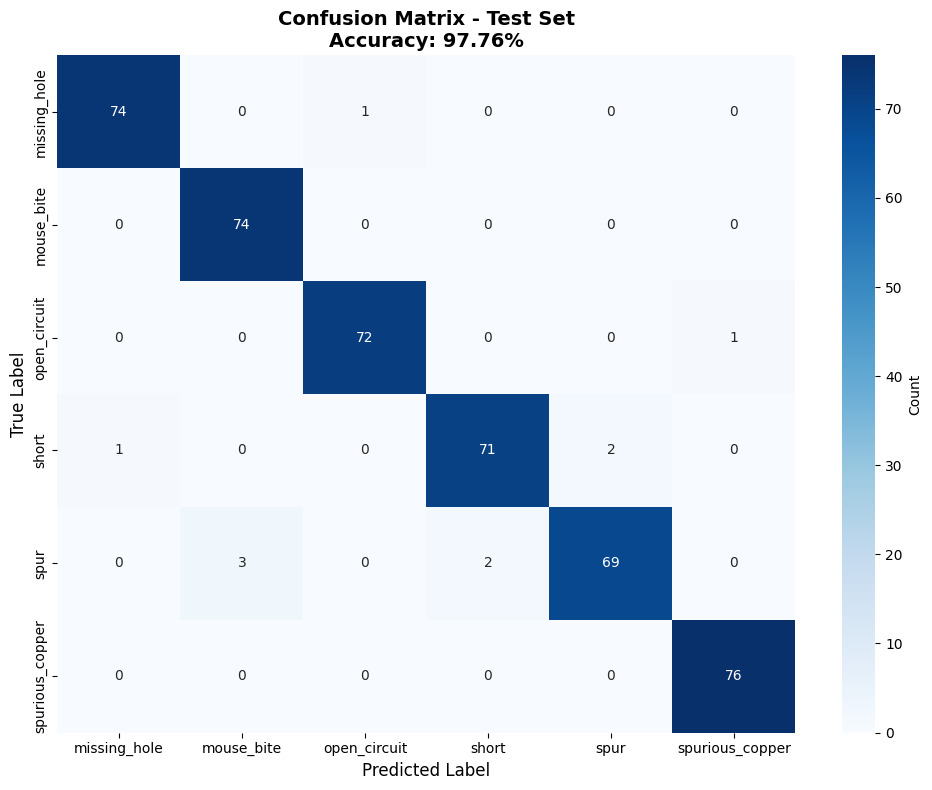

In [ ]:
# Confusion Matrix


# Compute confusion matrix
cm = confusion_matrix(true_indices, pred_indices)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - Test Set\nAccuracy: {accuracy*100:.2f}%',
          fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig(f'{VISUALIZATIONS_PATH}/test_confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved: {VISUALIZATIONS_PATH}/test_confusion_matrix.png")
plt.show()



📊 Classification Breakdown:
  Correctly classified: 436 (97.76%)
  Misclassified: 10 (2.24%)

📊 Misclassifications by True Class:
  missing_hole        :   1 errors out of  75 ( 1.33%)
  mouse_bite          :   0 errors out of  74 ( 0.00%)
  open_circuit        :   1 errors out of  73 ( 1.37%)
  short               :   3 errors out of  74 ( 4.05%)
  spur                :   5 errors out of  74 ( 6.76%)
  spurious_copper     :   0 errors out of  76 ( 0.00%)

📸 Visualizing Misclassifications...
✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/misclassifications.png


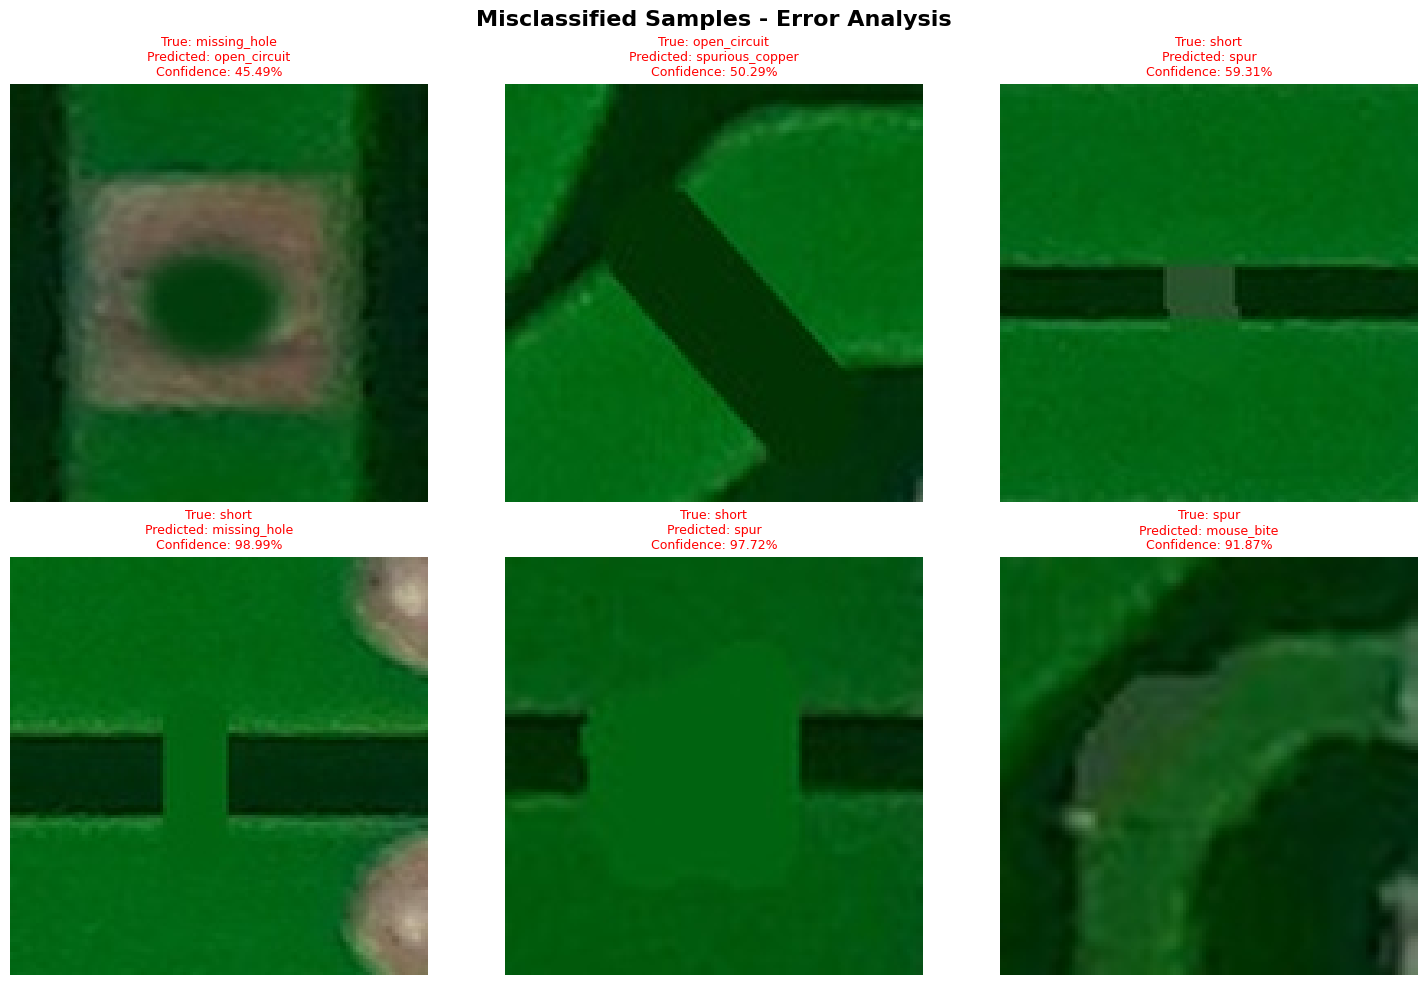

In [ ]:
#Error Analysis


# Find misclassified samples
misclassified = [p for p in prediction_details if not p['correct']]
correctly_classified = [p for p in prediction_details if p['correct']]

print(f"\n📊 Classification Breakdown:")
print(f"  Correctly classified: {len(correctly_classified)} ({len(correctly_classified)/len(prediction_details)*100:.2f}%)")
print(f"  Misclassified: {len(misclassified)} ({len(misclassified)/len(prediction_details)*100:.2f}%)")

# Analyze misclassifications by class
print(f"\n📊 Misclassifications by True Class:")
misclass_by_true = defaultdict(list)
for p in misclassified:
    misclass_by_true[p['true_label']].append(p)

for true_class in class_names:
    count = len(misclass_by_true[true_class])
    total = sum(1 for p in prediction_details if p['true_label'] == true_class)
    if total > 0:
        error_rate = count / total * 100
        print(f"  {true_class:<20s}: {count:>3d} errors out of {total:>3d} ({error_rate:>5.2f}%)")

# Visualize misclassifications
if len(misclassified) > 0:
    print(f"\n📸 Visualizing Misclassifications...")

    num_to_show = min(6, len(misclassified))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    fig.suptitle('Misclassified Samples - Error Analysis', fontsize=16, weight='bold')

    for idx in range(num_to_show):
        sample = misclassified[idx]

        # Load image
        img = Image.open(sample['image_path']).convert('RGB')

        # Display
        axes[idx].imshow(img)
        axes[idx].set_title(
            f"True: {sample['true_label']}\n"
            f"Predicted: {sample['predicted_label']}\n"
            f"Confidence: {sample['confidence']:.2%}",
            fontsize=9,
            color='red'
        )
        axes[idx].axis('off')

        # Red border
        for spine in axes[idx].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)

    # Hide unused subplots
    for idx in range(num_to_show, 6):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(f'{VISUALIZATIONS_PATH}/misclassifications.png', dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {VISUALIZATIONS_PATH}/misclassifications.png")
    plt.show()

✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/confidence_distribution.png


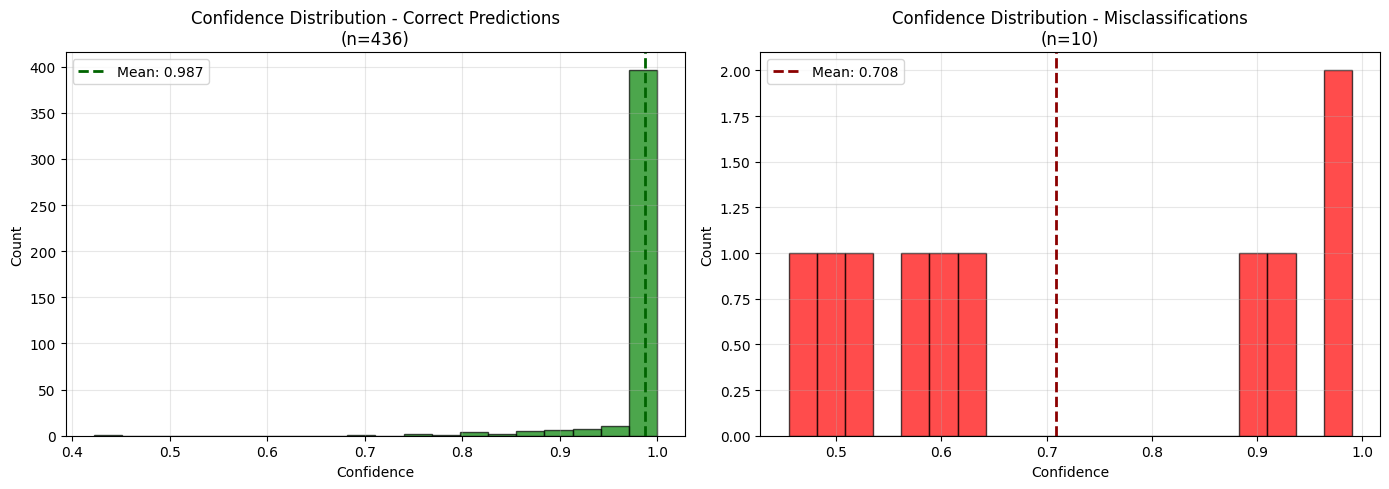


📊 Confidence Statistics:
  Correct predictions - Mean confidence: 0.9871
  Misclassifications - Mean confidence: 0.7085


In [ ]:
# Confidence Distribution Analysis
# Separate confidences for correct and incorrect predictions
correct_confidences = [p['confidence'] for p in correctly_classified]
incorrect_confidences = [p['confidence'] for p in misclassified]

# Plot confidence distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correct predictions
if correct_confidences:
    axes[0].hist(correct_confidences, bins=20, color='green', alpha=0.7, edgecolor='black')
    axes[0].axvline(np.mean(correct_confidences), color='darkgreen',
                    linestyle='--', linewidth=2, label=f'Mean: {np.mean(correct_confidences):.3f}')
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Confidence Distribution - Correct Predictions\n(n={len(correct_confidences)})')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

# Incorrect predictions
if incorrect_confidences:
    axes[1].hist(incorrect_confidences, bins=20, color='red', alpha=0.7, edgecolor='black')
    axes[1].axvline(np.mean(incorrect_confidences), color='darkred',
                    linestyle='--', linewidth=2, label=f'Mean: {np.mean(incorrect_confidences):.3f}')
    axes[1].set_xlabel('Confidence')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Confidence Distribution - Misclassifications\n(n={len(incorrect_confidences)})')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No Misclassifications!',
                ha='center', va='center', fontsize=16, weight='bold', color='green')
    axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.savefig(f'{VISUALIZATIONS_PATH}/confidence_distribution.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved: {VISUALIZATIONS_PATH}/confidence_distribution.png")
plt.show()

print(f"\n📊 Confidence Statistics:")
if correct_confidences:
    print(f"  Correct predictions - Mean confidence: {np.mean(correct_confidences):.4f}")
if incorrect_confidences:
    print(f"  Misclassifications - Mean confidence: {np.mean(incorrect_confidences):.4f}")


In [ ]:
# Generate Detailed Report
# Create comprehensive report
report = f"""
{'='*70}
CircuitGuard - Module 4: Evaluation Report
{'='*70}

1. OVERALL PERFORMANCE
{'='*70}
  Total Test Samples:     {len(prediction_details)}
  Correctly Classified:   {len(correctly_classified)} ({len(correctly_classified)/len(prediction_details)*100:.2f}%)
  Misclassified:          {len(misclassified)} ({len(misclassified)/len(prediction_details)*100:.2f}%)

  Accuracy:               {accuracy*100:.2f}%
  Precision (Weighted):   {precision:.4f}
  Recall (Weighted):      {recall:.4f}
  F1-Score (Weighted):    {f1:.4f}

2. PER-CLASS PERFORMANCE
{'='*70}
{'Class':<20s} | {'Precision':>10s} | {'Recall':>10s} | {'F1-Score':>10s} | {'Support':>10s} | {'Errors':>10s}
{'-'*90}
"""

for idx, class_name in enumerate(class_names):
    errors = len(misclass_by_true[class_name])
    report += f"{class_name:<20s} | {per_class_precision[idx]:>10.4f} | "
    report += f"{per_class_recall[idx]:>10.4f} | {per_class_f1[idx]:>10.4f} | "
    report += f"{per_class_support[idx]:>10d} | {errors:>10d}\n"

report += f"\n3. CONFIDENCE ANALYSIS\n{'='*70}\n"
if correct_confidences:
    report += f"  Correct Predictions:\n"
    report += f"    Mean Confidence:   {np.mean(correct_confidences):.4f}\n"
    report += f"    Median Confidence: {np.median(correct_confidences):.4f}\n"
    report += f"    Std Dev:           {np.std(correct_confidences):.4f}\n"

if incorrect_confidences:
    report += f"\n  Misclassifications:\n"
    report += f"    Mean Confidence:   {np.mean(incorrect_confidences):.4f}\n"
    report += f"    Median Confidence: {np.median(incorrect_confidences):.4f}\n"
    report += f"    Std Dev:           {np.std(incorrect_confidences):.4f}\n"

report += f"\n4. TARGET ACHIEVEMENT\n{'='*70}\n"
if accuracy >= 0.97:
    report += f"  ✅ TARGET MET: Accuracy ({accuracy*100:.2f}%) ≥ 97%\n"
else:
    report += f"  ⚠️ TARGET NOT MET: Accuracy ({accuracy*100:.2f}%) < 97%\n"

report += f"\n{'='*70}\n"
report += f"Report generated for Module 4: Evaluation and Prediction Testing\n"
report += f"{'='*70}\n"

# Save report
report_path = f'{REPORTS_PATH}/module4_evaluation_report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(report)
print(f"\n✅ Detailed report saved to: {report_path}")



CircuitGuard - Module 4: Evaluation Report

1. OVERALL PERFORMANCE
  Total Test Samples:     446
  Correctly Classified:   436 (97.76%)
  Misclassified:          10 (2.24%)
  
  Accuracy:               97.76%
  Precision (Weighted):   0.9776
  Recall (Weighted):      0.9776
  F1-Score (Weighted):    0.9775

2. PER-CLASS PERFORMANCE
Class                |  Precision |     Recall |   F1-Score |    Support |     Errors
------------------------------------------------------------------------------------------
missing_hole         |     0.9867 |     0.9867 |     0.9867 |         75 |          1
mouse_bite           |     0.9610 |     1.0000 |     0.9801 |         74 |          0
open_circuit         |     0.9863 |     0.9863 |     0.9863 |         73 |          1
short                |     0.9726 |     0.9595 |     0.9660 |         74 |          3
spur                 |     0.9718 |     0.9324 |     0.9517 |         74 |          5
spurious_copper      |     0.9870 |     1.0000 |     0.993

In [ ]:
# Save Predictions to CSV


# Create DataFrame
predictions_df = pd.DataFrame(prediction_details)

# Save to CSV
csv_path = f'{PREDICTIONS_PATH}/test_predictions.csv'
predictions_df.to_csv(csv_path, index=False)

print(f"✅ Predictions saved to: {csv_path}")
print(f"   Total records: {len(predictions_df)}")

#Save Module 4 Metadata


✅ Predictions saved to: /content/drive/MyDrive/CircuitGuard_Project/outputs/predictions/test_predictions.csv
   Total records: 446


In [ ]:
module4_metadata = {
    'module': 'Module_4_Evaluation',
    'test_results': {
        'total_samples': len(prediction_details),
        'correct': len(correctly_classified),
        'incorrect': len(misclassified),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1)
    },
    'per_class_metrics': {
        class_names[idx]: {
            'precision': float(per_class_precision[idx]),
            'recall': float(per_class_recall[idx]),
            'f1_score': float(per_class_f1[idx]),
            'support': int(per_class_support[idx]),
            'errors': len(misclass_by_true[class_names[idx]])
        }
        for idx in range(len(class_names))
    },
    'confidence_stats': {
        'correct_mean': float(np.mean(correct_confidences)) if correct_confidences else None,
        'incorrect_mean': float(np.mean(incorrect_confidences)) if incorrect_confidences else None
    },
    'target_achievement': {
        'target_accuracy': 97.0,
        'achieved_accuracy': float(accuracy * 100),
        'target_met': accuracy >= 0.97
    },
    'output_paths': {
        'predictions_csv': csv_path,
        'report': report_path,
        'visualizations': VISUALIZATIONS_PATH
    }
}

module4_metadata_path = f'{PROJECT_ROOT}/module4_metadata.json'
with open(module4_metadata_path, 'w') as f:
    json.dump(module4_metadata, f, indent=4)

print(f"✅ Module 4 metadata saved to: {module4_metadata_path}")


✅ Module 4 metadata saved to: /content/drive/MyDrive/CircuitGuard_Project/module4_metadata.json


In [ ]:
# Summary till now

print(f"  ✅ Total test samples evaluated: {len(prediction_details)}")
print(f"  ✅ Test accuracy: {accuracy*100:.2f}%")
print(f"  ✅ Correctly classified: {len(correctly_classified)}")
print(f"  ✅ Misclassified: {len(misclassified)}")
print(f"  ✅ Precision: {precision:.4f}")
print(f"  ✅ Recall: {recall:.4f}")
print(f"  ✅ F1-Score: {f1:.4f}")

if accuracy >= 0.97:
    print(f"\n🎉 TARGET ACHIEVED! Test accuracy ≥ 97%")
else:
    print(f"\n⚠️ Target: 97%, Achieved: {accuracy*100:.2f}%")

print(f"\n📁 Outputs Generated:")
print(f"  - Predictions CSV: {csv_path}")
print(f"  - Evaluation report: {report_path}")
print(f"  - Visualizations: {VISUALIZATIONS_PATH}")
print(f"  - Confusion matrix: test_confusion_matrix.png")
print(f"  - Sample predictions: sample_predictions.png")
print(f"  - Misclassifications: misclassifications.png")
print(f"  - Confidence distribution: confidence_distribution.png")


  ✅ Total test samples evaluated: 446
  ✅ Test accuracy: 97.76%
  ✅ Correctly classified: 436
  ✅ Misclassified: 10
  ✅ Precision: 0.9776
  ✅ Recall: 0.9776
  ✅ F1-Score: 0.9775

🎉 TARGET ACHIEVED! Test accuracy ≥ 97%

📁 Outputs Generated:
  - Predictions CSV: /content/drive/MyDrive/CircuitGuard_Project/outputs/predictions/test_predictions.csv
  - Evaluation report: /content/drive/MyDrive/CircuitGuard_Project/outputs/reports/module4_evaluation_report.txt
  - Visualizations: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations
  - Confusion matrix: test_confusion_matrix.png
  - Sample predictions: sample_predictions.png
  - Misclassifications: misclassifications.png
  - Confidence distribution: confidence_distribution.png
